In [15]:
import sys
sys.path.append("../../../") # Where to find utilssphering
import utilssphering
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [5]:
# Read CSV
match_rep_df = pd.read_csv("../../../checkpoints/match_rep_df.csv")
match_rep_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,z_plane,BF_Zplanes,spinning-disc,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites,Size_MB,Size_MB_std
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,NaN,1,10,6,1,NaN,no,0.45,dry,NaN,NaN,4,52.476334,0.000144
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,1,NaN,yes,0.45,dry,NaN,NaN,4,52.476514,0.000183
2,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,3,NaN,yes,0.45,dry,NaN,NaN,4,52.476631,0.000142
3,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,NaN,1,20,6,3,NaN,yes,0.75,dry,NaN,NaN,4,52.476629,0.000114
4,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,NaN,1,20,6,1,NaN,no,0.75,dry,NaN,NaN,9,52.476334,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4.0,1,20,5,12,13,NaN,1.00,water,NaN,NaN,4,8.003585,0.000044
180,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4.0,1,20,5,12,15,NaN,1.00,water,NaN,NaN,4,8.003585,0.000044
181,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,12,15,NaN,1.00,water,NaN,NaN,4,7.954439,0.000583
182,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,12,15,NaN,1.00,water,NaN,NaN,4,8.003584,0.000014


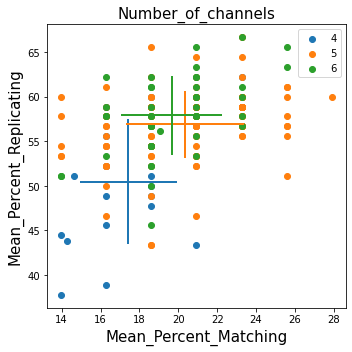

In [4]:
# A 

group = "Number_of_channels"

df_subset = match_rep_df[(match_rep_df["sphering"] == True)]
group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True
)
# Plot the errorbars
utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig,
    ax_=ax
)
        
fig.savefig("(A)-rep-vs-match-number_of_channels.png")

In [ ]:
# B 

# Find channel names from load_data_csvs
def find_channel_names(metadata_df, load_data_path):
    plates = []
    df = metadata_df.copy()
    for root, dirs, files in os.walk(load_data_path):
        for file in files:
            if "load_data_with_illum.csv" in file:
                path = os.path.join(root, file)
                plate = os.path.split(path)[0].split("/")[-1]
                plates.append(plate)
                if plate not in metadata_df["Assay_Plate_Barcode"].values:
                    print("No channel name source found for: ", path, plate)
                columns = pd.read_csv(path).columns.tolist()
                channels = sorted([i.replace("FileName_Orig", "") for i in columns if "FileName_Orig" in i])
                channels = ", ".join(channels)
                # df.loc[df["Assay_Plate_Barcode"] == plate, "channel_names"] = ", ".join(channels)
                df.loc[df["Assay_Plate_Barcode"] == plate, "channel_names"] = channels
    return df

experiment_df = find_channel_names(match_rep_df, "../../../../jump-scope/load_data_csv/")

def search_correlations(metadata_df, profile_path):
    """
    Reads *_normalized_feature_select_negcon_batch.csv.gz
    and performs a function on the dataframe 
    """
    df_list = []
    # metadata_df = metadata_df[~metadata_df["Batch"].str.contains("siteSub")]
    df = metadata_df.copy()
    df = df[~df["Batch"].str.contains("siteSub")]
    for ind, row in metadata_df.iterrows():
        df_path = os.path.join(profile_path, row["Batch"], row["Assay_Plate_Barcode"], f"{row['Assay_Plate_Barcode']}.csv.gz")
        df_path = glob.glob(df_path)[0]
        load_df = pd.read_csv(df_path)
        # cols = [i for i in load_df.columns if ("Golgi" in i and "Actin" in i and "Costes" in i) or 
        #                                         ("Golgi" in i and "DNA" in i and "Costes" in i) or
        #                                         ("Actin" in i and "DNA" in i and "Costes" in i) or
        #                                         ("AGP" in i)
        #                                         ]
        cols = [i for i in load_df.columns if ("Cells" in i and "Costes" in i)]
        # cols = [i for i in load_df.columns if i in ["Actin", "DNA", "ER", "Golgi", "Mito", "RNA"]]
        load_df = load_df[cols]
        # For the masked dataset (which represents one plate), aggregate all well values
        load_df.agg(np.mean)
        # Since the DF was masked by [cols], add back in the Batch, Assay_Plate_Barcode and channel_names, based on the row info
        load_df["Batch"], load_df["Assay_Plate_Barcode"], load_df["channel_names"] = [row["Batch"], row["Assay_Plate_Barcode"], row["channel_names"]]
        df_list.append(load_df)
    out_df = pd.concat(df_list)
    # Once concatenated, aggregate all values based on channel_name grouping
    out_df = out_df.groupby(
                        "channel_names",as_index=False).agg(np.mean)
    return out_df

corr_df = search_correlations(experiment_df, "../../../../jump-scope/profiles/")

# Find a subset of combinations
mask_cols = corr_df.columns[corr_df.columns.str.contains("Costes_Actin|channel_names")]
corr_df = corr_df[mask_cols]

plot_corr_df = corr_df[(corr_df["channel_names"] == "Actin, DNA, ER, Golgi, Mito, RNA")].dropna(axis=1).transpose().reset_index()

plot_corr_df.iloc[1:,:]

In [22]:
experiment_df[["Vendor", "channel_names"]][experiment_df["Vendor"] == "Nikon"]

,Vendor,channel_names
12,Nikon,"AGP, DNA, ER, Mito"
13,Nikon,"AGP, DNA, ER, Mito"
14,Nikon,"AGP, DNA, ER, Mito"
15,Nikon,"AGP, DNA, ER, Mito"
16,Nikon,"AGP, DNA, ER, Mito"
17,Nikon,"AGP, DNA, ER, Mito"
18,Nikon,"AGP, DNA, ER, Mito"
19,Nikon,"AGP, DNA, ER, Mito"
20,Nikon,"AGP, DNA, ER, Mito"
21,Nikon,"AGP, DNA, ER, Mito"


In [ ]:
# C